### HW5: Toxic Comment Classification with Spark

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.functions import vector_to_array
import pyspark.sql.functions as F
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, Word2Vec
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.classification import FMClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MultilabelClassificationEvaluator
import tqdm
import pandas as pd

Start spark local session

In [3]:
spark = SparkSession.builder\
        .master('local[32]')\
        .appName('HW5')\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

sc = spark.sparkContext

Read data

In [4]:
train = spark.read.csv('train.csv', sep=',', quote='\"', escape='\"', multiLine=True, header=True, inferSchema=True)
test = spark.read.csv('test.csv', sep=',', quote='\"', escape='\"', multiLine=True, header=True, inferSchema=True)
test_labels = spark.read.csv('test_labels.csv', sep=',', quote='\"', escape='\"', multiLine=True, header=True, inferSchema=True)
test = test.join(test_labels, 'id')

Train model

In [5]:
targets = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate',]
res = {
    'numFeatures':[],
    'pipe':[],
    #'model':[],
}

res.update({
    target:[] for target in targets
})

for numFeatures in tqdm.tqdm([10, 20, 50, 100]):
#for numFeatures in tqdm.tqdm([100]):
    scores = []
    tokenizer = Tokenizer(inputCol="comment_text", outputCol="words")
    hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="tf", numFeatures=numFeatures)
    idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="features")
    preprocessing = [tokenizer, hashingTF, idf,]

    pipeline = Pipeline(stages=[tokenizer, hashingTF, idf,])
    res['pipe'].append('tf_idf_logreg')
    res['numFeatures'].append(numFeatures)
    for target in targets:

        model = LogisticRegression(featuresCol=idf.getOutputCol(), labelCol=target)
        metrics = BinaryClassificationEvaluator(labelCol=model.getLabelCol(), rawPredictionCol=model.getRawPredictionCol())

        pipeline = Pipeline(stages=preprocessing + [model,])
        pipeline = pipeline.fit(train)
        res[target].append(metrics.evaluate(pipeline.transform(test)))

100%|██████████| 4/4 [20:14<00:00, 303.62s/it]


In [6]:
pd.DataFrame(res)

,numFeatures,pipe,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,10,tf_idf_logreg,0.635883,0.619228,0.658461,0.678476,0.648708,0.608368
1,20,tf_idf_logreg,0.653728,0.641461,0.675077,0.691512,0.677127,0.654684
2,50,tf_idf_logreg,0.671999,0.685680,0.705528,0.720725,0.700021,0.672718
3,100,tf_idf_logreg,0.722376,0.761274,0.750961,0.788325,0.753461,0.728204


In [7]:
for numFeatures in tqdm.tqdm([10, 20, 50, 100]):
    scores = []
    tokenizer = Tokenizer(inputCol="comment_text", outputCol="words")
    hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="tf", numFeatures=numFeatures)
    idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="features")
    preprocessing = [tokenizer, hashingTF, idf,]

    pipeline = Pipeline(stages=[tokenizer, hashingTF, idf,])
    res['pipe'].append('tf_idf_naiveBayes')
    res['numFeatures'].append(numFeatures)
    for target in targets:

        model = NaiveBayes(
                featuresCol=idf.getOutputCol(), 
                labelCol=target, 
                smoothing=1.0, 
                modelType="multinomial")
        metrics = BinaryClassificationEvaluator(labelCol=model.getLabelCol(), rawPredictionCol=model.getRawPredictionCol())

        pipeline = Pipeline(stages=preprocessing + [model,])
        pipeline = pipeline.fit(train)
        res[target].append(metrics.evaluate(pipeline.transform(test)))

pd.DataFrame(res)

100%|██████████| 4/4 [14:14<00:00, 213.70s/it]


,numFeatures,pipe,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,10,tf_idf_logreg,0.635883,0.619228,0.658461,0.678476,0.648708,0.608368
1,20,tf_idf_logreg,0.653728,0.641461,0.675077,0.691512,0.677127,0.654684
2,50,tf_idf_logreg,0.671999,0.685680,0.705528,0.720725,0.700021,0.672718
3,100,tf_idf_logreg,0.722376,0.761274,0.750961,0.788325,0.753461,0.728204
4,10,tf_idf_naiveBayes,0.640626,0.498888,0.637462,0.595308,0.635330,0.620397
5,20,tf_idf_naiveBayes,0.641366,0.499387,0.638537,0.597254,0.636410,0.622166
6,50,tf_idf_naiveBayes,0.641836,0.504088,0.639044,0.606435,0.637086,0.624230
7,100,tf_idf_naiveBayes,0.642066,0.506713,0.639695,0.608007,0.637777,0.624552


In [8]:
for numFeatures in tqdm.tqdm([10, 20, 50, 100]):
    scores = []
    tokenizer = Tokenizer(inputCol="comment_text", outputCol="words")
    w2v = Word2Vec(inputCol=tokenizer.getOutputCol(), outputCol="features", vectorSize=numFeatures)
    preprocessing = [tokenizer, w2v]

    pipeline = Pipeline(stages=[tokenizer, w2v])
    res['pipe'].append('w2v_logreg')
    res['numFeatures'].append(numFeatures)
    for target in targets:

        model = LogisticRegression(featuresCol=idf.getOutputCol(), labelCol=target)
        metrics = BinaryClassificationEvaluator(labelCol=model.getLabelCol(), rawPredictionCol=model.getRawPredictionCol())

        pipeline = Pipeline(stages=preprocessing + [model,])
        pipeline = pipeline.fit(train)
        res[target].append(metrics.evaluate(pipeline.transform(test)))

pd.DataFrame(res)

100%|██████████| 4/4 [3:19:25<00:00, 2991.26s/it]


,numFeatures,pipe,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,10,tf_idf_logreg,0.635883,0.619228,0.658461,0.678476,0.648708,0.608368
1,20,tf_idf_logreg,0.653728,0.641461,0.675077,0.691512,0.677127,0.654684
2,50,tf_idf_logreg,0.671999,0.685680,0.705528,0.720725,0.700021,0.672718
3,100,tf_idf_logreg,0.722376,0.761274,0.750961,0.788325,0.753461,0.728204
4,10,tf_idf_naiveBayes,0.640626,0.498888,0.637462,0.595308,0.635330,0.620397
5,20,tf_idf_naiveBayes,0.641366,0.499387,0.638537,0.597254,0.636410,0.622166
6,50,tf_idf_naiveBayes,0.641836,0.504088,0.639044,0.606435,0.637086,0.624230
7,100,tf_idf_naiveBayes,0.642066,0.506713,0.639695,0.608007,0.637777,0.624552
8,10,w2v_logreg,0.819433,0.931987,0.853904,0.850394,0.848471,0.877106
9,20,w2v_logreg,0.829149,0.933299,0.861449,0.895365,0.855900,0.880298


Results

In [14]:
df = pd.DataFrame(res)
df['mean_score'] = df[targets].mean(axis=1)

In [27]:
df

,numFeatures,pipe,toxic,severe_toxic,obscene,threat,insult,identity_hate,mean_score
0,10,tf_idf_logreg,0.635883,0.619228,0.658461,0.678476,0.648708,0.608368,0.641521
1,20,tf_idf_logreg,0.653728,0.641461,0.675077,0.691512,0.677127,0.654684,0.665598
2,50,tf_idf_logreg,0.671999,0.685680,0.705528,0.720725,0.700021,0.672718,0.692778
3,100,tf_idf_logreg,0.722376,0.761274,0.750961,0.788325,0.753461,0.728204,0.750767
4,10,tf_idf_naiveBayes,0.640626,0.498888,0.637462,0.595308,0.635330,0.620397,0.604669
5,20,tf_idf_naiveBayes,0.641366,0.499387,0.638537,0.597254,0.636410,0.622166,0.605853
6,50,tf_idf_naiveBayes,0.641836,0.504088,0.639044,0.606435,0.637086,0.624230,0.608786
7,100,tf_idf_naiveBayes,0.642066,0.506713,0.639695,0.608007,0.637777,0.624552,0.609802
8,10,w2v_logreg,0.819433,0.931987,0.853904,0.850394,0.848471,0.877106,0.863549
9,20,w2v_logreg,0.829149,0.933299,0.861449,0.895365,0.855900,0.880298,0.875910


In [16]:
df.to_excel('results_main.xlsx')

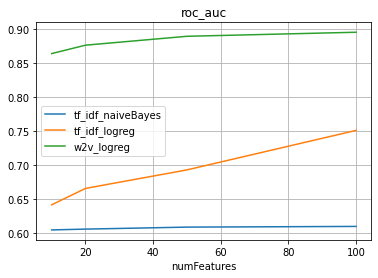

In [26]:
pipe = 'tf_idf_naiveBayes'
ax = df[df['pipe'] == pipe]\
    .set_index('numFeatures')\
    .rename(columns={'roc_auc': pipe})['mean_score']\
    .plot(grid=True, label=pipe)

for pipe in ['tf_idf_logreg', 'w2v_logreg']: 
    df[df['pipe'] == pipe]\
    .set_index('numFeatures')\
    .rename(columns={'roc_auc': pipe})['mean_score']\
    .plot(grid=True, label=pipe, ax=ax)

ax.set_title('roc_auc')
ax.legend()